In [106]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.stats import norm
from arch import arch_model
import warnings
import seaborn as sns
import math
import random
import matplotlib.pyplot as plt

In [300]:
warnings.filterwarnings("ignore")
plt.style.use('dark_background')

In [301]:
stocks = [ 'aapl', 't', 'blk' , 'msft', ]
r      = 0.05

In [302]:
def get_adj_close(ticker, start, end):  # get adjusted close price from yahoo finance
    return yf.download(ticker, start=start, end=end)['Adj Close']

def get_portfolio(stocks, start, end):  # get portfolio of stocks
    portfolio = pd.DataFrame()
    for stock in stocks:
        portfolio[stock] = get_adj_close(stock, start, end)
    return portfolio

In [303]:
portfolio  = get_portfolio(stocks, '2022-09-30', '2023-09-30') if 'portfolio' not in locals() else eval('portfolio')

## Market risk

In [304]:
# expected short fall
def expected_shortfall(returns, alpha, value_at_risk_fn):  # of the time that we loose, how much do we loose
    return returns[returns <= - value_at_risk_fn(returns, alpha)].mean()

In [305]:
# value at risk functions
def non_param_value_at_risk(returns, alpha):  # stupid
    return - returns.quantile(alpha, interpolation='lower')

def non_param_probability_weighted_value_at_risk(returns, alpha, l=0.995):  # time weighted
    returns *= np.array([l ** i for i in range(len(returns))])[:, np.newaxis]
    return - returns.quantile(alpha, interpolation='lower')

def param_value_at_risk(returns, alpha):  # assuming normal distribution
    mu = returns.mean()    # mean
    sigma = returns.std()  # volatility
    return - norm.ppf(alpha, mu, sigma)

def ewma_value_at_risk(returns, lambda_, alpha):  # exponentially weighted moving average
    # this is almost certainly wrong
    return - returns.ewm(alpha=1-lambda_).mean().quantile(alpha, interpolation='lower')

def garch_value_at_risk(returns, alpha):  # generalized autoregressive conditional heteroskedasticity
    # use arch_model function from arch library
    am = arch_model(returns, mean='Zero', vol='GARCH', p=1, o=0, q=1, dist='Normal')
    res = am.fit(disp='off')
    forecasts = res.forecast(horizon=1, start=0)
    return - forecasts.variance.values[-1, :].item() ** 0.5 * norm.ppf(alpha)

In [75]:

returns    = portfolio.pct_change().dropna()
# expected_shortfall(returns, 0.05, non_param_value_at_risk)
# non_param_probability_weighted_value_at_risk(returns, 0.05)
# param_value_at_risk(returns, 0.05)
# ewma_value_at_risk(returns, 0.94, 0.05)
# garch_value_at_risk(returns, 0.05)

In [76]:
x = np.random.randn(8)
w = np.array([0.1, 0.2, 0.3, 0.4])
y = np.zeros(x.shape[0])

def moving_average(x, w):
    for i in range(x.shape[0]):
        x_   = x[max(0, i - w.shape[0] + 1): i + 1]
        w_   = w[:x_.shape[0]]
        y[i] = np.sum(x_ * w_) / np.sum(w_)
    return y

# auto regressive


## Derivatives pricing


$$S_t = \mu S_t dt + \sigma S_t dW_t$$


In [77]:
# geometric brownian motion model fitting for stock prices
def geometric_brownian_motion_model_fit(returns):
    mu = returns.mean()
    sigma = returns.std()
    return mu, sigma

def geometric_brownian_motion_model_simulate(mu, sigma, start_price, days, dt):
    prices = np.zeros(days)
    prices[0] = start_price
    for i in range(1, days):
        prices[i] = prices[i - 1] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * np.random.normal())
    return prices

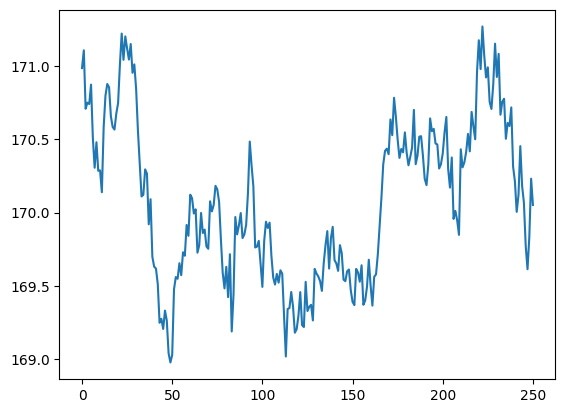

In [79]:
S = portfolio['aapl']
R = np.log(S / S.shift(1)).dropna()
mu, sigma = geometric_brownian_motion_model_fit(R)
start_price = S[-1]
days = len(S)
dt = 1 / days
prices = geometric_brownian_motion_model_simulate(mu, sigma, S[-1], days, dt)
plt.plot(prices)
# prices is the simulated stock price for the next year

In [327]:
S = portfolio['aapl']
R = np.log(S / S.shift(1)).dropna()
# R = S.pct_change().dropna()
mu, sigma = R.mean(), R.std()
""" start_price = S[-1]
days = 10000
dt = 1 / days
fig, ax = plt.subplots(figsize=(20, 10))
for i in range(1000):
    prices = geometric_brownian_motion_model_simulate(mu, sigma, S[-1], days, dt)
    ax.plot(prices, linewidth=0.8, alpha=0.1)
plt.show() """

' start_price = S[-1]\ndays = 10000\ndt = 1 / days\nfig, ax = plt.subplots(figsize=(20, 10))\nfor i in range(1000):\n    prices = geometric_brownian_motion_model_simulate(mu, sigma, S[-1], days, dt)\n    ax.plot(prices, linewidth=0.8, alpha=0.1)\nplt.show() '

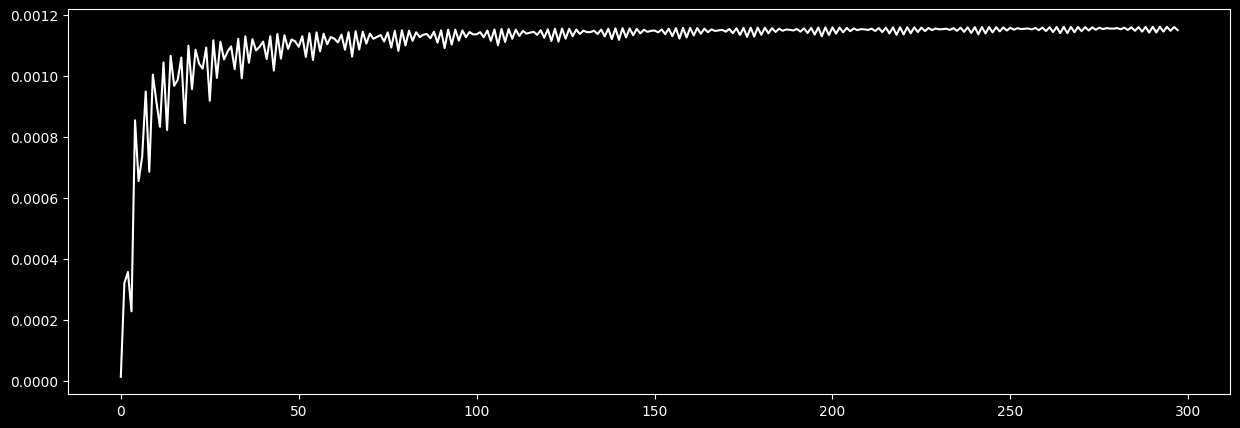

In [328]:
def binomial_tree(S_0, r, sigma, n, K, direction = 'call'):

    dt = 0.25 / n
    U  = np.exp(sigma * np.sqrt(dt))
    D  = 1 / U
    R  = np.exp(r * dt) - 1
    q  = (np.exp(r * dt) - D) / (U - D)

    stock_tree  = np.zeros((n + 1, n + 1))
    intrin_tree = np.zeros((n + 1, n + 1))
    option_tree = np.zeros((n + 1, n + 1))

    for i in range(0, n + 1):
        for j in range (0, i + 1):
            stock_tree[j, i]  = S_0 * U ** (i - j) * (D ** j)
            intrin_tree[j, i] = np.maximum(stock_tree[j, i] - K, 0)

    for i in range(n, -1, -1):
        for j in range(0, i + 1):
            if i == n:
                option_tree[j, i] = intrin_tree[j, i]; continue
            if direction == 'call':
                option_tree[j, i] = 1 / (1 + R) * (option_tree[j, i + 1] * q + option_tree[j + 1, i + 1] * (1 - q))
            if direction == 'put': 
                option_tree[j, i] = 1 / (1 + R) * (option_tree[j, i + 1] * (1 - q) + option_tree[j + 1, i + 1] * q)

    option_price = option_tree[0, 0]  
    return option_price

option_prices = [binomial_tree(S[-1], r , sigma, n, S[-1] + 2, 'put') for n in range(2, 300)]
fig, ax       = plt.subplots(figsize = (15,5)); ax.plot(option_prices, 'w');

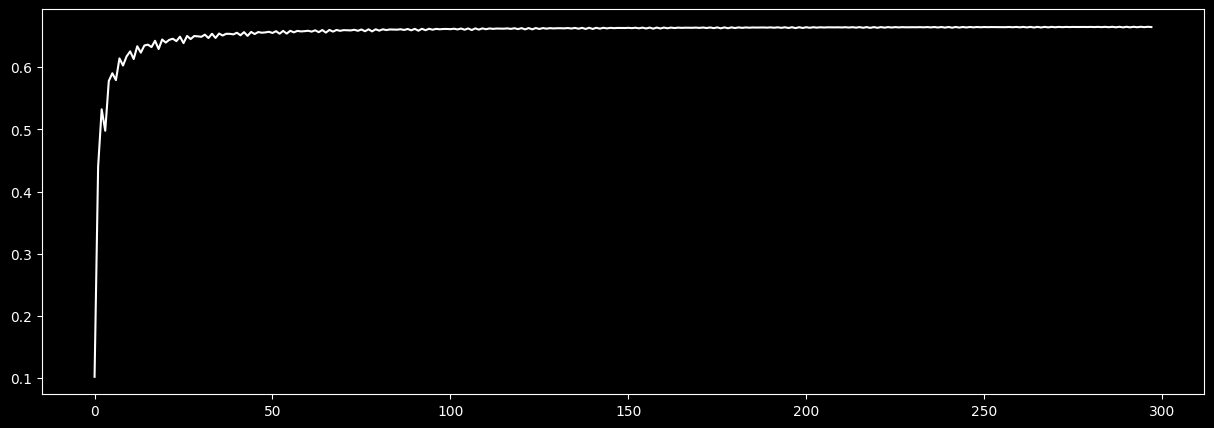

In [329]:
option_prices = [binomial_tree(S[-1], r , sigma, n, S[-1] + 2, 'call') for n in range(2, 300)]
fig, ax       = plt.subplots(figsize = (15,5)); ax.plot(option_prices, 'w');

## Delta hedging in the Black-Scholes model

In [18]:
# delta hedge
def delta_hedge(S, K, T, r, sigma, N, M, W):
    dt = T / N
    delta = []
    for i in range(M):
        S_t, t = geometric_brownian_motion(S, r, sigma, W[i], T, N)
        delta.append((atm_call_price(S_t[-1], K, T, r, sigma) - atm_call_price(S_t[-2], K, T, r, sigma)) / (S_t[-1] - S_t[-2]))
    return delta

stock = get_adj_close(stocks['Apple'], '2018-01-01', '2019-01-01')

[*********************100%%**********************]  1 of 1 completed


## Credit Value Adjustment